# Validation Analysis - Figures

In [72]:
from pathlib import Path

import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
SAVE_FIGS = True
REPO_ROOT = Path('/Users/rwegener/repos/chesapeake_mhw')

In [3]:
# Open SST from satellite and CBP stations
dtypes = {'Station': str, 'Latitude': float, 'Longitude': float, 'SampleDate': str,
          'sst_cbp': float, 'geopolar': float, 'mur': float, 'ostia': float}
path = REPO_ROOT / 'data/03_processed' / 'SST_satellites_cbp_stations.csv'
wq_sst = pd.read_csv(path, parse_dates=[3], skiprows=[1], dtype=dtypes)

In [4]:
path = REPO_ROOT / 'data/03_processed' / 'SSTanom_satellites_cbp_stations.csv'
dtypes = {'Station': str, 'SampleDate': str, 'Latitude': float, 'Longitude': float, 
          'anom_cbp': float, 'clim_geopolar': float, 'sst_geopolar': float, 
          'anom_geopolar': float, 'clim_mur': float, 'sst_mur': float, 'anom_mur': float,
          'clim_ostia': float, 'sst_ostia': float, 'anom_ostia': float}
wq_anom = pd.read_csv(path, parse_dates=[3], skiprows=[1], dtype=dtypes)
# Longitude and SampleDate are being fussy for some reason
wq_anom.Longitude = wq_anom.Longitude.astype(float)
wq_anom.SampleDate = pd.to_datetime(wq_anom.SampleDate)

In [5]:
# Number of stations being processed in anomaly calculation
len(wq_anom.groupby('Station').count())

51

## Pre-processing

### Raw SST

In [6]:
wq_sst['geopolar_err'] = wq_sst['geopolar'] - wq_sst['sst_cbp']
wq_sst['mur_err'] = wq_sst['mur'] - wq_sst['sst_cbp']
wq_sst['ostia_err'] = wq_sst['ostia'] - wq_sst['sst_cbp']

In [7]:
mur_nonan = wq_sst[~wq_sst['mur'].isnull()][['sst_cbp', 'mur']]
geop_nonan = wq_sst[~wq_sst['geopolar'].isnull()][['sst_cbp', 'geopolar']]
ostia_nonan = wq_sst[~wq_sst['ostia'].isnull()][['sst_cbp', 'ostia']]

### SST Anomaly

In [8]:
wq_anom['geopanom_err'] = wq_anom['anom_geopolar'] - wq_anom['anom_cbp']
wq_anom['muranom_err'] = wq_anom['anom_mur'] - wq_anom['anom_cbp']
wq_anom['ostiaanom_err'] = wq_anom['anom_ostia'] - wq_anom['anom_cbp']

In [9]:
muranom_nonan = wq_anom[~wq_anom['anom_mur'].isnull()][['anom_cbp', 'anom_mur']]
geopanom_nonan = wq_anom[~wq_anom['anom_geopolar'].isnull()][['anom_cbp', 'anom_geopolar']]
ostiaanom_nonan = wq_anom[~wq_anom['anom_ostia'].isnull()][['anom_cbp', 'anom_ostia']]

## Compute Mean Bias

In [10]:
def compute_mean_bias(error_series, name='no_name_given'):
    err = error_series.dropna()
    mean_bias = err.sum() / len(err)
    print('Mean bias of', name, 'is: ', np.round(mean_bias, 4))
    return mean_bias

### Raw SST

In [11]:
mur_bias = compute_mean_bias(wq_sst.mur_err, 'MUR')
geopolar_bias = compute_mean_bias(wq_sst.geopolar_err, 'Geo-Polar')
ostia_bias = compute_mean_bias(wq_sst.ostia_err, 'OSTIA')

Mean bias of MUR is:  -0.5196
Mean bias of Geo-Polar is:  -0.4978
Mean bias of OSTIA is:  -0.4933


### SST Anomaly

In [12]:
mur_anom_bias = compute_mean_bias(wq_anom.anom_mur - wq_anom.anom_cbp, 'MUR')
geopolar_anom_bias = compute_mean_bias(wq_anom.anom_geopolar - wq_anom.anom_cbp, 'Geo-Polar')
ostia_anom_bias = compute_mean_bias(wq_anom.anom_ostia - wq_anom.anom_cbp, 'OSTIA')

Mean bias of MUR is:  0.0007
Mean bias of Geo-Polar is:  0.0024
Mean bias of OSTIA is:  -0.0995


## Compute $R^2$

### Raw SST

In [13]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    mur_nonan.sst_cbp, mur_nonan.mur)

print('MUR: r squared', r_val**2)

MUR: r squared 0.9549784314563379


In [14]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    geop_nonan.sst_cbp, geop_nonan.geopolar)

print('Geo-Polar: r squared', r_val**2)

Geo-Polar: r squared 0.9658509696514481


In [15]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    ostia_nonan.sst_cbp, ostia_nonan.ostia)

print('OSTIA: r squared', r_val**2)

OSTIA: r squared 0.9642040071539276


### SST Anomaly

In [16]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    muranom_nonan.anom_cbp, muranom_nonan.anom_mur)

print('MUR: r squared', r_val**2)

MUR: r squared 0.5307318934846117


In [17]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    geopanom_nonan.anom_cbp, geopanom_nonan.anom_geopolar)

print('Geo-Polar: r squared', r_val**2)

Geo-Polar: r squared 0.7030799388399511


In [18]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    ostiaanom_nonan.anom_cbp, ostiaanom_nonan.anom_ostia)

print('OSTIA: r squared', r_val**2)

OSTIA: r squared 0.6697752461542693


## Computing slope and intercept values with robust regression

[https://www.statsmodels.org/stable/rlm.html](https://www.statsmodels.org/stable/rlm.html)

References:
- SO [example](https://stackoverflow.com/questions/46606082/using-huber-scale-and-location-estimator-in-statsmodel)
- Penn State [course webpage](https://online.stat.psu.edu/stat501/lesson/t/t.1/t.1.1-robust-regression-methods)
- statsmodels [RLMdocs](https://www.statsmodels.org/stable/generated/statsmodels.robust.robust_linear_model.RLM.html)
- [graphs](https://www.statsmodels.org/stable/rlm_techn1.html) for the weight function
- SO [post](https://stackoverflow.com/questions/31655196/how-to-get-r-squared-for-robust-regression-rlm-in-statsmodels) arguing against R2 when using robust regression

In [19]:
def robust_regression(x_values, y_values, name='no_name_given'):
    model = sm.RLM(y_values, sm.add_constant(x_values), 
                   M=sm.robust.norms.TukeyBiweight())
    results = model.fit()
    try:
        # attempt to retrieve value for SST
        rlm_slope = results.params.sst_cbp
    except AttributeError:
        # if it doesn't exist assume anom and retrieve anom_cbp params
        rlm_slope = results.params.anom_cbp
    rlm_inter = results.params.const
    print(name, 'slope', np.round(rlm_slope, 4), 
          'and intercept', np.round(rlm_inter, 4))
    return rlm_slope, rlm_inter

### Raw SST

In [20]:
mur_slope, mur_inter = robust_regression(mur_nonan.sst_cbp, mur_nonan.mur, 'MUR')
geopolar_slope, geopolar_inter = robust_regression(
    geop_nonan.sst_cbp, geop_nonan.geopolar, 'Geo-Polar')
ostia_slope, ostia_inter = robust_regression(
    ostia_nonan.sst_cbp, ostia_nonan.ostia, 'OSTIA')

MUR slope 0.9825 and intercept 0.1456
Geo-Polar slope 0.976 and intercept 0.1394
OSTIA slope 0.9737 and intercept 0.2179


### SST Anomaly

In [21]:
muranom_slope, muranom_inter = robust_regression(
    muranom_nonan.anom_cbp, muranom_nonan.anom_mur, 'MUR')
geopanom_slope, geopanom_inter = robust_regression(
    geopanom_nonan.anom_cbp, geopanom_nonan.anom_geopolar, 'Geo-Polar')
ostiaanom_slope, ostiaanom_inter = robust_regression(
    ostiaanom_nonan.anom_cbp, ostiaanom_nonan.anom_ostia, 'OSTIA')

MUR slope 0.8605 and intercept 0.1868
Geo-Polar slope 0.8153 and intercept 0.0125
OSTIA slope 0.7809 and intercept -0.0352


## Compute RMSE

In [22]:
def compute_rmse(error_series, name='no_name_given'):
    rmse = np.sqrt((error_series**2).sum() / error_series.count())
    print('RMSE', name, ':', np.round(rmse, 4))
    return rmse

### Raw SST

In [23]:
mur_rmse = compute_rmse(wq_sst.mur_err, 'MUR')
gepolar_rmse = compute_rmse(wq_sst.geopolar_err, 'Geo-Polar')
ostia_rmse = compute_rmse(wq_sst.ostia_err, 'OSTIA')

RMSE MUR : 1.8142
RMSE Geo-Polar : 1.5727
RMSE OSTIA : 1.6033


### SST Anomaly

In [24]:
muranom_rmse = compute_rmse(wq_anom.muranom_err, 'MUR')
gepolaranom_rmse = compute_rmse(wq_anom.geopanom_err, 'Geo-Polar')
ostiaanom_rmse = compute_rmse(wq_anom.ostiaanom_err, 'OSTIA')

RMSE MUR : 1.4178
RMSE Geo-Polar : 1.0017
RMSE OSTIA : 1.0581


## Hexbin plots for distribution

In [25]:
def mx_plus_b(x, slope, intercept):
    return slope * x + intercept

### Raw SST

In [26]:
# This would work if I could install pandas>=2.0
# wq_sst[['geopolar', 'mur', 'ostia']].max(axis=None)

This shorter method should work so long as there aren't any rows that have nan for all three satellites (shouldn't this get removed in an earlier notebook?)

In [27]:
# Find min/max values to use consistently across all three subplots
ymax = wq_sst[['geopolar', 'mur', 'ostia']].max().max()
ymin = wq_sst[['geopolar', 'mur', 'ostia']].min().min()

xmax = wq_sst.sst_cbp.max()
xmin = wq_sst.sst_cbp.min()

print(xmin, xmax, ymin, ymax)

-0.8 32.2 -1.8 30.967


In [28]:
# Define shorter names for the input data
x_geop = geop_nonan.sst_cbp
y_geop = geop_nonan.geopolar

x_mur = mur_nonan.sst_cbp
y_mur = mur_nonan.mur

x_ostia = ostia_nonan.sst_cbp
y_ostia = ostia_nonan.ostia

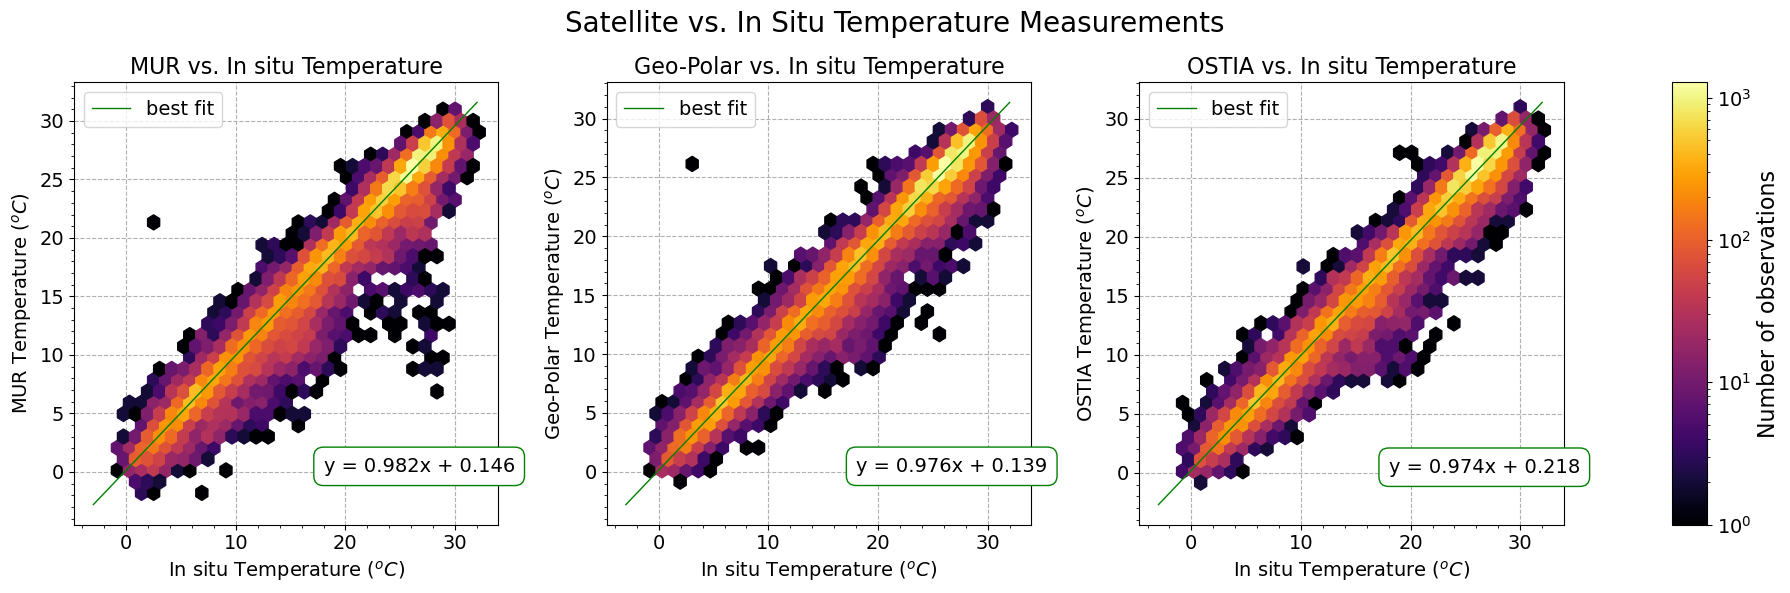

In [29]:
# Create a plot with 3 grids for the data and one grid for the colorbar
gridspec = {'width_ratios': [1.2, 1.2, 1.2, 0.1]}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw=gridspec)
fig.suptitle('Satellite vs. In Situ Temperature Measurements', size=20)

# Set properties for box around line of best fit
bbox_props = {'boxstyle': 'round', 'facecolor': 'white', 'pad': 0.5, 
              'edgecolor': 'green'}

# Add MUR heatmap
mur_plot = ax1.hexbin(x_mur, y_mur, gridsize=30, bins='log', cmap='inferno', 
                      extent=(xmin, xmax, ymin, ymax))
# Add MUR best fit line
ax1.plot([-3, 32], [mx_plus_b(-3, mur_slope, mur_inter), 
                     mx_plus_b(32, mur_slope, mur_inter)], 
         color='green', label='best fit', linewidth=1)
ax1.set_ylabel('MUR Temperature ($^oC$)', fontsize=14)
ax1.set_title('MUR vs. In situ Temperature', size=16)
ax1.text(18, 0, 'y = {m}x + {b}'.format(m=mur_slope.round(3), 
                                    b=mur_inter.round(3)), bbox=bbox_props,
                                    fontdict={'fontsize': 14})

# Add Geo-Polar heatmap
geop_plot = ax2.hexbin(x_geop, y_geop, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# Add Geo-Polar best fit line
ax2.plot([-3, 32], [mx_plus_b(-3, geopolar_slope, geopolar_inter), 
                     mx_plus_b(32, geopolar_slope, geopolar_inter)], 
         color='green', label='best fit', linewidth=1)
ax2.set_ylabel('Geo-Polar Temperature ($^oC$)', fontsize=14)
ax2.set_title('Geo-Polar vs. In situ Temperature', fontsize=16)
ax2.text(18, 0, 'y = {m}x + {b}'.format(m=geopolar_slope.round(3), 
                                    b=geopolar_inter.round(3)), bbox=bbox_props,
                                        fontdict={'fontsize': 14})

# Add OSTIA heatmap
ost_plot = ax3.hexbin(x_ostia, y_ostia, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# Add OSTIA best fit line
ax3.plot([-3, 32], [mx_plus_b(-3, ostia_slope, ostia_inter), 
                     mx_plus_b(32, ostia_slope, ostia_inter)], 
         color='green', label='best fit', linewidth=1)
ax3.set_ylabel('OSTIA Temperature ($^oC$)', fontsize=14)
ax3.set_title('OSTIA vs. In situ Temperature', size=16)
ax3.text(18, 0, 'y = {m}x + {b}'.format(m=ostia_slope.round(3), 
                                    b=ostia_inter.round(3)), bbox=bbox_props,
                                    fontdict={'fontsize': 14})


# Standardize axes settings
for ax in (ax1, ax2, ax3):
    ax.legend(loc="upper left", fontsize=14)
    # label the x axis
    ax.set_xlabel('In situ Temperature ($^oC$)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.minorticks_on()
    # add gridlines
    ax.set_axisbelow(True)
    ax.grid(linestyle='--', linewidth=0.8)

# Add shared colorbar
cb = fig.colorbar(geop_plot, cax=ax4)
cb.set_label('Number of observations', fontsize=16)
cb.ax.tick_params(labelsize=14)

# Turn back on for SST Values
fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/02_validation' / 
                'satellite_validation_raw_hexplot.jpeg', 
                bbox_inches='tight', dpi=700)


### SST Anomaly

In [30]:
# Find min/max values to use consistently across all three subplots
ymax = wq_anom[['anom_geopolar', 'anom_mur', 'anom_ostia']].max().max()
ymin = wq_anom[['anom_geopolar', 'anom_mur', 'anom_ostia']].min().min()

xmax = wq_anom.anom_cbp.max()
xmin = wq_anom.anom_cbp.min()

print(xmin, xmax, ymin, ymax)

-8.4037 8.6793 -14.7833 6.2431


In [31]:
# Define shorter names for the input data
x_geop = geopanom_nonan.anom_cbp
y_geop = geopanom_nonan.anom_geopolar

x_mur = muranom_nonan.anom_cbp
y_mur = muranom_nonan.anom_mur

x_ostia = ostiaanom_nonan.anom_cbp
y_ostia = ostiaanom_nonan.anom_ostia

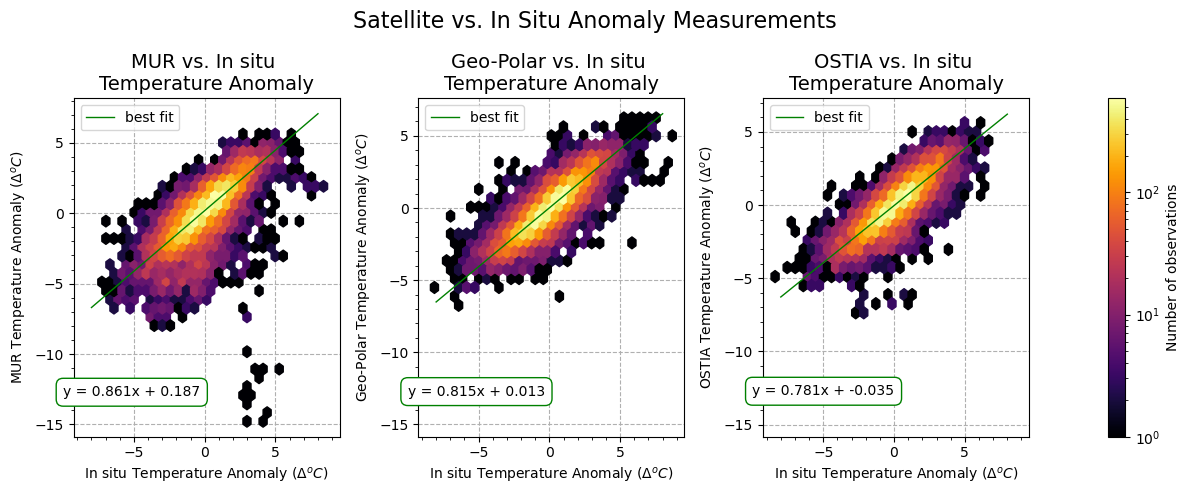

In [32]:
gridspec = {'width_ratios': [1.5, 1.5, 1.5, 0.1]}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5), gridspec_kw=gridspec)
fig.suptitle('Satellite vs. In Situ Anomaly Measurements', size=16)

bbox_props = {'boxstyle': 'round', 'facecolor': 'white',
             'pad': 0.5, 'edgecolor': 'green'}

# Add MUR data to axis 1
mur_plot = ax1.hexbin(x_mur, y_mur, gridsize=30, bins='log', cmap='inferno', 
                      extent=(xmin, xmax, ymin, ymax))
# plot the line of linear fit
ax1.plot([-8, 8], [mx_plus_b(-8, muranom_slope, muranom_inter), 
                     mx_plus_b(8, muranom_slope, muranom_inter)], 
         color='green', label='best fit', linewidth=1)
ax1.set_ylabel('MUR Temperature Anomaly ($\Delta^oC$)')
ax1.set_title('MUR vs. In situ \nTemperature Anomaly', size=14)
ax1.text(-10, -13, 'y = {m}x + {b}'.format(m=muranom_slope.round(3), 
                                    b=muranom_inter.round(3)), bbox=bbox_props)

# Add Geo-Polar data to axis 2
geop_plot = ax2.hexbin(x_geop, y_geop, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# plot the line of linear fit
ax2.plot([-8, 8], [mx_plus_b(-8, geopanom_slope, geopanom_inter), 
                     mx_plus_b(8, geopanom_slope, geopanom_inter)], 
         color='green', label='best fit', linewidth=1)
ax2.set_ylabel('Geo-Polar Temperature Anomaly ($\Delta^oC$)')
ax2.set_title('Geo-Polar vs. In situ \nTemperature Anomaly', size=14)
ax2.text(-10, -13, 'y = {m}x + {b}'.format(m=geopanom_slope.round(3), 
                                    b=geopanom_inter.round(3)), bbox=bbox_props)

# Add OSTIA data to axis 3
ostia_plot = ax3.hexbin(x_ostia, y_ostia, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# plot the line of linear fit
ax3.plot([-8, 8], [mx_plus_b(-8, ostiaanom_slope, ostiaanom_inter), 
                     mx_plus_b(8, ostiaanom_slope, ostiaanom_inter)], 
         color='green', label='best fit', linewidth=1)
ax3.set_ylabel('OSTIA Temperature Anomaly ($\Delta^oC$)')
ax3.set_title('OSTIA vs. In situ \nTemperature Anomaly', size=14)
ax3.text(-10, -13, 'y = {m}x + {b}'.format(m=ostiaanom_slope.round(3), 
                                    b=ostiaanom_inter.round(3)), bbox=bbox_props)

# Standardize axes settings
for ax in (ax1, ax2, ax3):
    ax.legend(loc="upper left")
    # label the x axis
    ax.set_xlabel('In situ Temperature Anomaly ($\Delta^oC$)')
    ax.minorticks_on()
    # add gridlines
    ax.set_axisbelow(True)
    ax.grid(linestyle='--', linewidth=0.8)

# Add shared colorbar
cb = fig.colorbar(geop_plot, cax=ax4)
cb.set_label('Number of observations')

# Turn back on for SST Values
fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/02_validation' /
                'satellite_validation_anomaly_hexplot.jpeg', 
                bbox_inches='tight', dpi=700)


## Spatial Distribution of SST Error

Create geodataframe with average values at each station location

In [33]:
# Calculate averages for each observation station (location)
temps_mean = wq_sst.groupby(['Station']) \
        .mean(numeric_only=True).reset_index()

In [34]:
# Convert into a geodataframe
temps_mean_gpd = gpd.GeoDataFrame(
    temps_mean, geometry=gpd.points_from_xy(
        temps_mean['Longitude'], temps_mean['Latitude']
    ), 
    crs='epsg:4326'
)

In [35]:
# Find min/max values to use consistently across all three subplots
maxes = temps_mean_gpd[['geopolar_err', 'mur_err', 'ostia_err']].max().max()
mins = temps_mean_gpd[['geopolar_err', 'mur_err', 'ostia_err']].min().min()

print(mins, maxes)

-10.702 2.0814285714285714


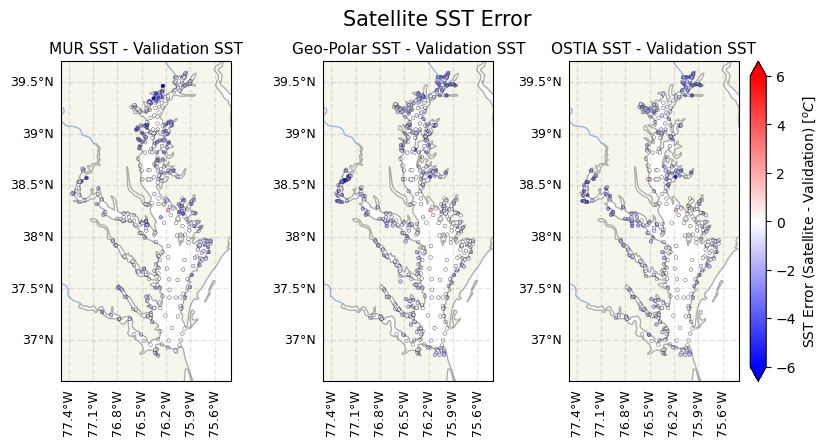

In [36]:
gs = GridSpec(1, 4, width_ratios=(1, 1, 1, 0.1))
gs.update(top=.85, bottom=0.05, left=0.05, right=.95, hspace=0.2, wspace=0.2)

f = plt.figure(figsize=(9, 4))

f.suptitle('Satellite SST Error', size=15, ha='center')

# initialize the cartopy axes
axes = [f.add_subplot(g, projection=ccrs.PlateCarree()) for g in (gs[0], gs[1], gs[2])]

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 9, 'rotation': 90}
    gl.ylabel_style = {'size': 9}

vmin, vmax = -6, 6

# Add MUR mean error
temps_mean_gpd.plot(ax=axes[0], column='mur_err', markersize=7, cmap='bwr', 
                    vmin=vmin, vmax=vmax, edgecolor='black', linewidth=0.2)
axes[0].set_title('MUR SST - Validation SST', size=11)

# Add Geo-Polar mean error
temps_mean_gpd.plot(
    ax=axes[1], column='geopolar_err', markersize=7, cmap='bwr', vmin=vmin, vmax=vmax, 
    edgecolor='black', linewidth=0.2,
)
axes[1].set_title('Geo-Polar SST - Validation SST', size=11)

# Add OSTIA mean error
ostia_plot = temps_mean_gpd.plot(ax=axes[2], column='ostia_err', markersize=7, cmap='bwr', 
                    vmin=vmin, vmax=vmax, edgecolor='black', linewidth=0.2,
                    legend=True, 
    legend_kwds={'label': "SST Error (Satellite - Validation) [$^oC$]", 'extend': 'both'})
axes[2].set_title('OSTIA SST - Validation SST', size=11)

# save
if SAVE_FIGS:
    plt.savefig(
        REPO_ROOT / 'figures/02_validation' / 
        'sst_error_spatial_distribution.png', dpi=1000, bbox_inches='tight'
    )

## Long term trend in Anomaly error

In [37]:
# Calculate averages for each observation station (location)
anoms_mean = wq_anom.groupby(['Station']) \
        .mean(numeric_only=True).reset_index()

In [38]:
# Convert to geodataframe
anoms_mean_gpd = gpd.GeoDataFrame(
    anoms_mean, geometry=gpd.points_from_xy(
        anoms_mean['Longitude'], anoms_mean['Latitude']
    ), 
    crs='epsg:4326'
)

In [39]:
def get_slope(df, remove_insignificant=True):
    '''
    Slope of the long term trend in geopolar error.
    Units: degrees / year
    '''
    df = df.sort_values('SampleDate')
    # Remove nan values
    df = df[~df.geopanom_err.isnull()]
    # Extract input arrays for regression
    x = df.SampleDate.apply(lambda x: x.toordinal())
    y = df.geopanom_err
    if len(df) == 0:
        df['slope'] = np.nan
    else:
        # Slope of long term trend
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        # Multiply by 365 so units are degrees / year not degrees / day
        df['slope'] = slope * 365
        if remove_insignificant:
            if p_value >= 0.05:
                print('removing p value')
                df['slope'] = np.nan
    print('--------------')
    return df

In [40]:
slopes = wq_anom.groupby(['Station'], group_keys=True).apply(get_slope)

--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
removing p value
--------------
removing p value
--------------
removing p value
--------------
removing p value
--------------
--------------
--------------
--------------
--------------
removing p value
--------------
removing p value
--------------
--------------
--------------
--------------
--------------
removing p value
--------------
--------------
removing p value
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------


delete?

In [242]:
cb21 = wq_anom[wq_anom.Station == 'CB1.1']

In [233]:
cb21 = cb21[~cb21.geopanom_err.isnull()]

In [234]:
x = cb21.SampleDate.apply(lambda x: x.toordinal())
y = cb21.geopanom_err
# Slope of long term trend
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

In [235]:
slope*365

0.14166499596615773

In [214]:
slopes

Station SampleDate  Latitude  Longitude  anom_cbp  \
Station                                                           
CB1.1   0       CB1.1 2003-01-15   39.5479   -76.0848   -2.9500   
        1       CB1.1 2003-03-12   39.5479   -76.0848   -3.3500   
        2       CB1.1 2003-04-09   39.5479   -76.0848   -5.6200   
        3       CB1.1 2003-04-23   39.5479   -76.0848   -0.1200   
        4       CB1.1 2003-05-07   39.5479   -76.0848   -0.4321   
...               ...        ...       ...        ...       ...   
WT8.3   14739   WT8.3 2023-08-08   38.8425   -76.5341    0.2083   
        14740   WT8.3 2023-09-13   38.8425   -76.5341    4.0848   
        14741   WT8.3 2023-10-17   38.8425   -76.5341   -0.5042   
        14742   WT8.3 2023-11-16   38.8425   -76.5341    0.1381   
        14743   WT8.3 2023-12-12   38.8425   -76.5341    0.8738   

               clim_geopolar  sst_geopolar  anom_geopolar  clim_mur  sst_mur  \
Station                                                                        
CB1.1   0             3.3992          1.63        -1.7692    3.8769    2.076   
        1             4.4956          0.94        -3.5556    4.3557   -0.304   
        2            10.5856          7.52        -3.0656    9.7780    4.105   
        3            10.5856          9.19        -1.3956    9.7780    5.754   
        4            14.2421          9.67        -4.5721   16.0494    9.337   
...                      ...           ...            ...       ...      ...   
WT8.3   14739        26.4688         26.86         0.3912       NaN      NaN   
        14740        23.4165         26.58         3.1635       NaN      NaN   
        14741        18.0821         18.01        -0.0721       NaN      NaN   
        14742        12.5143         12.96         0.4457       NaN      NaN   
        14743         7.0552          8.37         1.3148       NaN      NaN   

               anom_mur  clim_ostia  sst_ostia  anom_ostia  geopanom_err  \
Station                                                                    
CB1.1   0       -1.8009      3.6144        NaN         NaN        1.1808   
        1       -4.6597      5.1571        NaN         NaN       -0.2056   
        2       -5.6729     11.0994        NaN         NaN        2.5544   
        3       -4.0240     11.0994        NaN         NaN       -1.2756   
        4       -6.7124     15.1550        NaN         NaN       -4.1400   
...                 ...         ...        ...         ...           ...   
WT8.3   14739       NaN     26.8494      26.69     -0.1594        0.1829   
        14740       NaN     24.0041      26.21      2.2059       -0.9213   
        14741       NaN     18.3747      18.12     -0.2547        0.4321   
        14742       NaN     12.8394      12.79     -0.0494        0.3076   
        14743       NaN      7.5323       8.30      0.7676        0.4410   

               muranom_err  ostiaanom_err     slope  
Station                                              
CB1.1   0           1.1491            NaN  0.141665  
        1          -1.3097            NaN  0.141665  
        2          -0.0529            NaN  0.141665  
        3          -3.9040            NaN  0.141665  
        4          -6.2803            NaN  0.141665  
...                    ...            ...       ...  
WT8.3   14739          NaN        -0.3677  0.050916  
        14740          NaN        -1.8789  0.050916  
        14741          NaN         0.2495  0.050916  
        14742          NaN        -0.1875  0.050916  
        14743          NaN        -0.1062  0.050916  

[13661 rows x 18 columns]

resume

In [41]:
stats_gpd = gpd.GeoDataFrame(
    slopes, geometry=gpd.points_from_xy(slopes.Longitude, slopes.Latitude), crs="EPSG:4326"
)

In [48]:
print(anoms_mean_gpd.geopanom_err.min())
print(anoms_mean_gpd.geopanom_err.max())

-0.008392553191489361
0.020046768060836495


In [43]:
slopes

Station SampleDate  Latitude  Longitude  anom_cbp  \
Station                                                           
CB1.1   0       CB1.1 2003-01-15   39.5479   -76.0848   -2.9500   
        1       CB1.1 2003-03-12   39.5479   -76.0848   -3.3500   
        2       CB1.1 2003-04-09   39.5479   -76.0848   -5.6200   
        3       CB1.1 2003-04-23   39.5479   -76.0848   -0.1200   
        4       CB1.1 2003-05-07   39.5479   -76.0848   -0.4321   
...               ...        ...       ...        ...       ...   
WT8.3   14739   WT8.3 2023-08-08   38.8425   -76.5341    0.2083   
        14740   WT8.3 2023-09-13   38.8425   -76.5341    4.0848   
        14741   WT8.3 2023-10-17   38.8425   -76.5341   -0.5042   
        14742   WT8.3 2023-11-16   38.8425   -76.5341    0.1381   
        14743   WT8.3 2023-12-12   38.8425   -76.5341    0.8738   

               clim_geopolar  sst_geopolar  anom_geopolar  clim_mur  sst_mur  \
Station                                                                        
CB1.1   0             3.3992          1.63        -1.7692    3.8769    2.076   
        1             4.4956          0.94        -3.5556    4.3557   -0.304   
        2            10.5856          7.52        -3.0656    9.7780    4.105   
        3            10.5856          9.19        -1.3956    9.7780    5.754   
        4            14.2421          9.67        -4.5721   16.0494    9.337   
...                      ...           ...            ...       ...      ...   
WT8.3   14739        26.4688         26.86         0.3912       NaN      NaN   
        14740        23.4165         26.58         3.1635       NaN      NaN   
        14741        18.0821         18.01        -0.0721       NaN      NaN   
        14742        12.5143         12.96         0.4457       NaN      NaN   
        14743         7.0552          8.37         1.3148       NaN      NaN   

               anom_mur  clim_ostia  sst_ostia  anom_ostia  geopanom_err  \
Station                                                                    
CB1.1   0       -1.8009      3.6144        NaN         NaN        1.1808   
        1       -4.6597      5.1571        NaN         NaN       -0.2056   
        2       -5.6729     11.0994        NaN         NaN        2.5544   
        3       -4.0240     11.0994        NaN         NaN       -1.2756   
        4       -6.7124     15.1550        NaN         NaN       -4.1400   
...                 ...         ...        ...         ...           ...   
WT8.3   14739       NaN     26.8494      26.69     -0.1594        0.1829   
        14740       NaN     24.0041      26.21      2.2059       -0.9213   
        14741       NaN     18.3747      18.12     -0.2547        0.4321   
        14742       NaN     12.8394      12.79     -0.0494        0.3076   
        14743       NaN      7.5323       8.30      0.7676        0.4410   

               muranom_err  ostiaanom_err     slope  \
Station                                               
CB1.1   0           1.1491            NaN  0.141665   
        1          -1.3097            NaN  0.141665   
        2          -0.0529            NaN  0.141665   
        3          -3.9040            NaN  0.141665   
        4          -6.2803            NaN  0.141665   
...                    ...            ...       ...   
WT8.3   14739          NaN        -0.3677  0.050916   
        14740          NaN        -1.8789  0.050916   
        14741          NaN         0.2495  0.050916   
        14742          NaN        -0.1875  0.050916   
        14743          NaN        -0.1062  0.050916   

                                 geometry  
Station                                    
CB1.1   0      POINT (-76.08480 39.54790)  
        1      POINT (-76.08480 39.54790)  
        2      POINT (-76.08480 39.54790)  
        3      POINT (-76.08480 39.54790)  
        4      POINT (-76.08480 39.54790)  
...                                   ...  
WT8.3   14739  POINT (-76.53410 38.84250)  


In [52]:
anoms_mean_gpd.geopanom_err.max()

0.020046768060836495

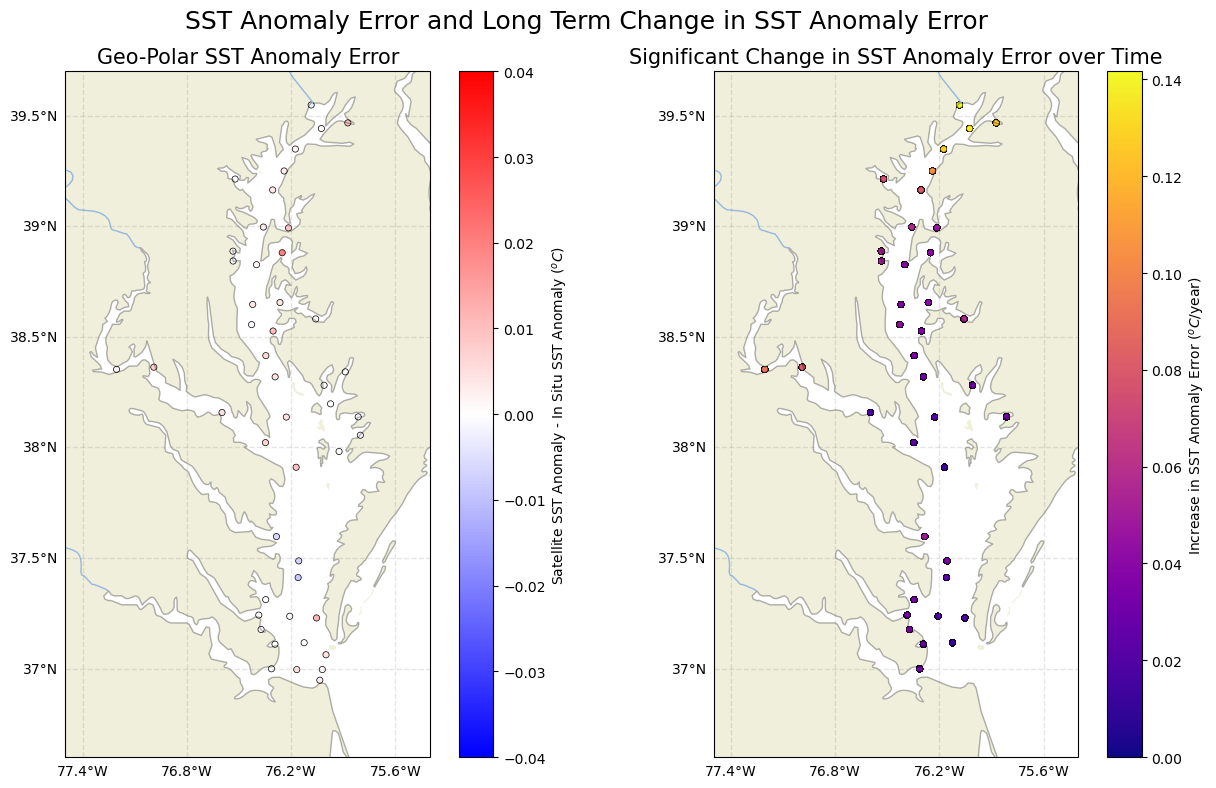

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(13, 8)
fig.suptitle('SST Anomaly Error and Long Term Change in SST Anomaly Error', size=18)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in (ax1, ax2):
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAND)

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    ax.tick_params(axis='both', labelsize=16)

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlocator = mticker.FixedLocator([-77.4, -76.8, -76.2, -75.6])

# Add mean error
anoms_mean_gpd.plot(ax=ax1, column='geopanom_err', markersize=20, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Satellite SST Anomaly - In Situ SST Anomaly ($^oC$)"}, 
                    vmin=-0.04, vmax=0.04, edgecolor='black', linewidth=0.5)
ax1.set_title('Geo-Polar SST Anomaly Error', size=15)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=ax2, column='slope', markersize=20, cmap='plasma',
                legend=True, vmin=0,
                    legend_kwds={'label': "Increase in SST Anomaly Error ($^oC$/year)"}, 
                    edgecolor='black', linewidth=0.3)
ax2.set_title('Significant Change in SST Anomaly Error over Time', size=15)

plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(
        REPO_ROOT / 'figures/02_validation' / 'sst_anomaly_error_spatial_distribution.png', 
        dpi=400, bbox_inches='tight'
    )

In [247]:
# fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()})

# fig.set_size_inches(17, 14)
# # fig.tight_layout()
# fig.suptitle('Satellite Measurement Anomaly Distribution Description in the Chesapeake Bay', size=16)
# # fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# # my_cmap = matplotlib.cm.get_cmap('viridis')
# # my_cmap.set_bad('black')

# for ax in axes.flatten():
#     # Add background features
#     ax.add_feature(cfeature.COASTLINE, alpha=0.3)
#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     ax.add_feature(cfeature.RIVERS)
#     # ax.coastlines()

#     ax.set_extent([-77.5, -75.4, 36.6, 39.7])

#     # Add and format gridlines. Remove top and right labels
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=1, color='gray', alpha=0.2, linestyle='--')
#     gl.top_labels, gl.right_labels = False, False

# # Add mean error
# anoms_mean_gpd.plot(ax=axes[0, 0], column='geopanom_err', markersize=12, cmap='bwr', legend=True, 
#                     legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
#                     vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
# axes[0, 0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# # Standard Deviation
# std_gpd.plot(ax=axes[0, 1], column='geopanom_err', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "Standard Deviation"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[0, 1].set_title('Standard Deviation', size=12)

# # Add long term trend slope
# # Can't get pandas to show nan values. Maybe set to 0 then change colormap?
# stats_gpd.plot(ax=axes[0, 2], column='slope', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "Increase in $^oC$/year"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[0, 2].set_title('Significant Change in Anomaly Error over time', size=12)


# # Skew
# stats_gpd.plot(ax=axes[1, 0], column='skew', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "Skew"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[1, 0].set_title('Skew', size=12)

# # Kurtosis
# stats_gpd.plot(ax=axes[1, 1], column='kurt', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "kurtosis"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[1, 1].set_title('kurtosis', size=12)

# # 95th Percentile
# stats_gpd.plot(ax=axes[1, 2], column='95th', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "95th percentile"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[1, 2].set_title('95th percentile', size=12)


# plt.tight_layout()

# # save
# if SAVE_FIGS:
#     plt.savefig(REPO_ROOT /'figures/validation_analysis/map_distribution_statistics.png', 
#                 dpi=400, bbox_inches='tight')

## Hovm&#246;ller Plot for Seasonality of Error



Create the matricies using anomaly SST error

In [152]:
def create_hovmoller_matrix(temps: pd.DataFrame, satellite_name: str) -> pd.DataFrame:
    """
    temps - pandas dataframe of ...
    satellite_name
    """
    temps = temps.set_index(pd.to_datetime(temps['SampleDate']))
    temps = temps.resample('M').mean(numeric_only=True)
    
    temps = temps[[satellite_name + '_err']]
    
    temps['month'] = temps.index.month
    temps['year'] = temps.index.year
    
    matrix = temps.pivot(index='year', columns='month')
    
    return matrix

In [153]:
# wq_sst_mur = wq_sst[~wq_sst.mur_err.isnull()]
# wq_sst_gp = wq_sst[~wq_sst.geopolar_err.isnull()]

In [154]:
matrix_geopanom = create_hovmoller_matrix(wq_anom[~wq_anom.geopanom_err.isnull()], 'geopanom')

Plot the SST anomaly error for Geo-Polar only

In [155]:
print(matrix_geopanom.min().min())
print(matrix_geopanom.max().max())

-1.9544845070422536
1.753074358974359


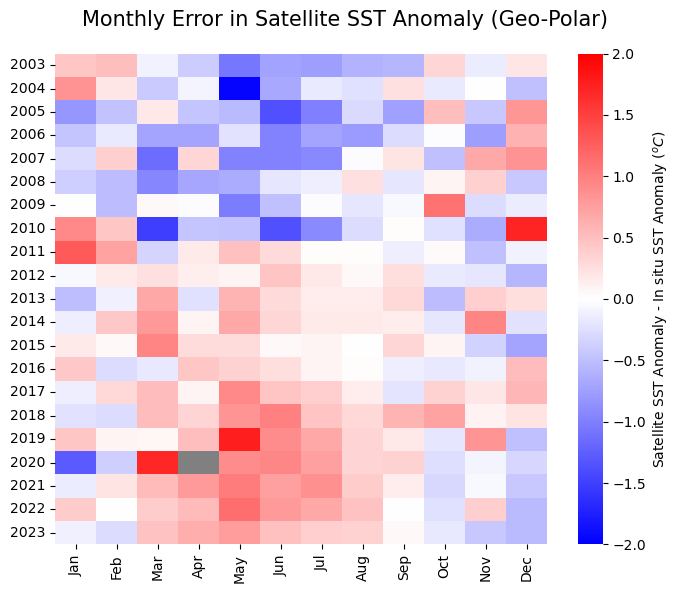

In [156]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 6)
fig.suptitle('Monthly Error in Satellite SST Anomaly (Geo-Polar)', size=15)

vmin, vmax = -2, 2
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
          'Oct', 'Nov', 'Dec']

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geopanom, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST Anomaly - In situ SST Anomaly ($^oC$)'})
ax.set_xticklabels(months, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(
        REPO_ROOT / 'figures/02_validation' / 'ssta_error_hovemoller_geopolar.png', 
        dpi=350, bbox_inches='tight'
    )

## Supplemental Figures

Plot the SST anomaly error for all three satellites

In [157]:
matrix_muranom = create_hovmoller_matrix(wq_anom[~wq_anom.muranom_err.isnull()], 'muranom')
matrix_ostiaanom = create_hovmoller_matrix(wq_anom[~wq_anom.ostiaanom_err.isnull()], 'ostiaanom')

In [158]:
print('Min:')
print(matrix_muranom.min().min())
print(matrix_geopanom.min().min())
print(matrix_ostiaanom.min().min())
print('Max:')
print(matrix_geopanom.max().max())
print(matrix_muranom.max().max())
print(matrix_ostiaanom.max().max())

Min:
-4.643715714285714
-1.9544845070422536
-3.0362808219178086
Max:
1.753074358974359
2.2966439024390244
1.7935625


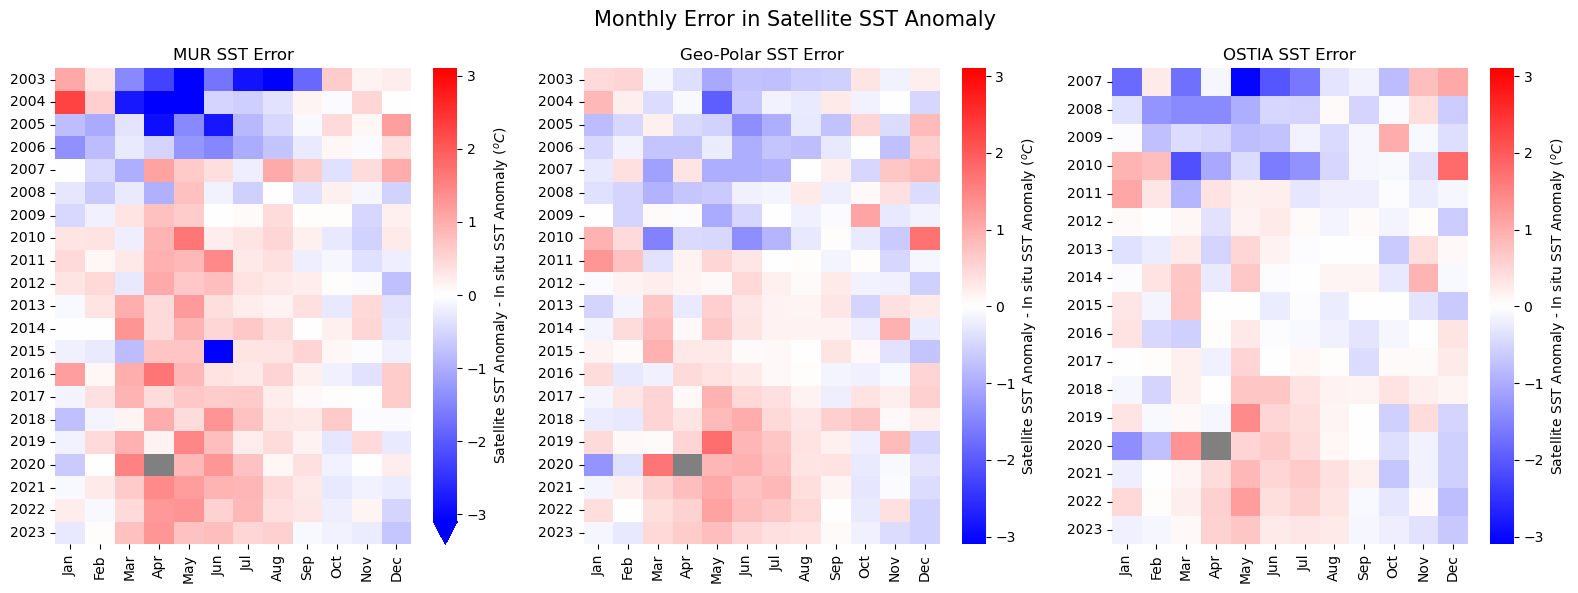

In [162]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 6)
fig.suptitle('Monthly Error in Satellite SST Anomaly', size=15)

vmin, vmax = -3.1, 3.1
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
          'Oct', 'Nov', 'Dec']

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')


sns.heatmap(matrix_muranom, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST Anomaly - In situ SST Anomaly ($^oC$)', 
                      'extend': 'min'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('MUR SST Error')

sns.heatmap(matrix_geopanom, ax=ax2, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
           cbar_kws={'label': 'Satellite SST Anomaly - In situ SST Anomaly ($^oC$)'})
ax2.set_xticklabels(months, rotation=90)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Geo-Polar SST Error')

sns.heatmap(matrix_ostiaanom, ax=ax3, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST Anomaly - In situ SST Anomaly ($^oC$)'})
ax3.set_xticklabels(months, rotation=90)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('OSTIA SST Error')

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(
        REPO_ROOT / 'figures/04_supplementalmaterial' / 'ssta_error_hovmoller_allsats.png', 
        dpi=350, bbox_inches='tight'
    )

Plot the SST error (not anomaly) for all three satellites

In [163]:
matrix_geop = create_hovmoller_matrix(wq_sst[~wq_sst.geopolar_err.isnull()], 'geopolar')
matrix_mur = create_hovmoller_matrix(wq_sst[~wq_sst.mur_err.isnull()], 'mur')
matrix_ostia = create_hovmoller_matrix(wq_sst[~wq_sst.ostia_err.isnull()], 'ostia')

In [164]:
print('Min:')
print(matrix_mur.min().min())
print(matrix_geop.min().min())
print(matrix_ostia.min().min())
print('Max:')
print(matrix_geop.max().max())
print(matrix_mur.max().max())
print(matrix_ostia.max().max())

Min:
-6.3029231884057975
-3.7280920289855075
-5.101132945736434
Max:
1.4851329545454546
2.5971458333333333
1.7469511363636363


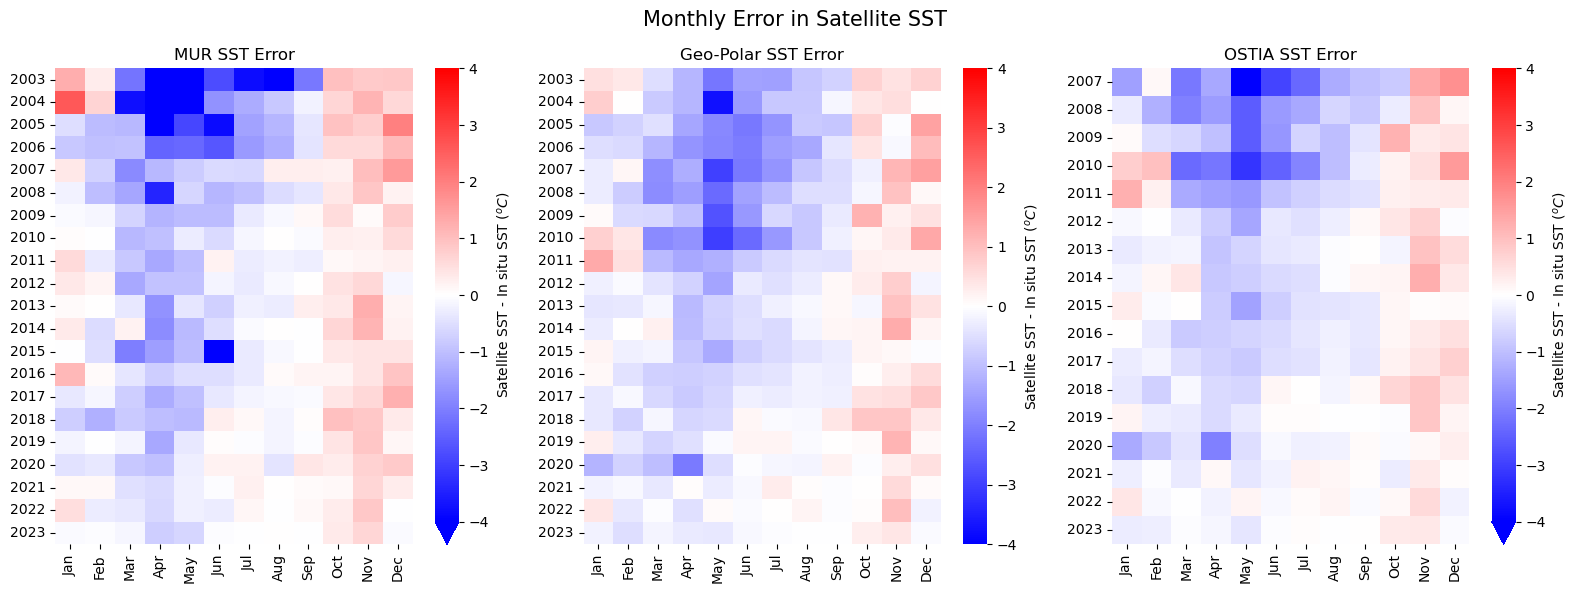

In [166]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 6)
fig.suptitle('Monthly Error in Satellite SST', size=15)

vmin, vmax = -4, 4
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
          'Oct', 'Nov', 'Dec']

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')


sns.heatmap(matrix_mur, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 
                      'extend': 'min'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('MUR SST Error')

sns.heatmap(matrix_geop, ax=ax2, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
           cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)'})
ax2.set_xticklabels(months, rotation=90)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Geo-Polar SST Error')

sns.heatmap(matrix_ostia, ax=ax3, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 
                      'extend': 'min'})
ax3.set_xticklabels(months, rotation=90)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('OSTIA SST Error')

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(
        REPO_ROOT / 'figures/04_supplementalmaterial' / 'sst_error_hovmoller_allsats.png', 
        dpi=350, bbox_inches='tight'
    )

## Delete all below

### Quantifying Long Term trend by month

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
                                                                     matrix_geop.mean(axis=1))

print('Geopolar: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
    matrix_mur.mean(axis=1))

print('MUR: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

In [ ]:
def linearregression(row):
    _, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    row['p_value'] = p_value
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return p_value

In [ ]:
def significant_slopes(row):
    slope, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    # if p_value > 0.05:
    #     slope = np.nan
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return slope

In [ ]:
geo_pvals = matrix_geop.apply(linearregression, axis=0)
geo_slope = matrix_geop.apply(significant_slopes, axis=0)

In [ ]:
mur_pvals = matrix_mur.apply(linearregression, axis=0)
mur_slope = matrix_mur.apply(significant_slopes, axis=0)

In [ ]:
geo_pvals.index = geo_pvals.index.droplevel(0)
mur_pvals.index = mur_pvals.index.droplevel(0)

geo_slope.index = geo_slope.index.droplevel(0)
mur_slope.index = mur_slope.index.droplevel(0)

In [ ]:
all_pvals = pd.concat([geo_pvals, mur_pvals], axis=1, keys=['geopolar', 'mur'])
all_slopes = pd.concat([geo_slope, mur_slope], axis=1, keys=['geopolar', 'mur'])

In [ ]:
geo_slope = pd.DataFrame(geo_slope)
geo_slope['significant'] = geo_slope > 0.05

In [ ]:
geo_slope = geo_slope.rename({0: 'error_slope'}, axis=1)

In [ ]:
geo_slope

In [ ]:
geo_pvals

### Ploting Temporal Trends

In [ ]:
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

In [ ]:
# import matplotlib.patches as patches

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1.6]})
fig.suptitle('Error in Satellite Anomaly over Time', size=14)

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite - In situ ($^oC$)'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('Month')
ax1.set_ylabel('Year')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
colors=[]
for i in range(12):
    if geo_pvals.iloc[i] > 0.05:
        # append light grey if the trend is not significant
        colors.append((0.878, 0.878, 0.878, 1))
    else:
        colors.append(sm.to_rgba(i+1))

matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
matrix_geop.plot(ax=ax2, color=colors, legend=False)

ax1.set_title('Geopolar Anomaly Error')
ax2.set_title('Significant Trends')


plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(REPO_ROOT /'figures/validation_analysis/hovmoller_error_withmonths.png', 
                dpi=350, bbox_inches='tight')

In [ ]:
matrix_geop.min().min(), matrix_geop.max().max()

In [ ]:
matrix_mur.min().min(), matrix_mur.max().max()

## Error Histogram

**TODO:** What is the point of the plot? Is it to show that the distribtuion is just a bit wider/narrow in each satellite? Or is it to show that one outlier?

In [ ]:
mur_mean, mur_std = wq_sst_mur.mur_diff.mean(), wq_sst_mur.mur_diff.std()
gp_mean, gp_std = wq_sst_gp.geopolar_diff.mean(), wq_sst_gp.geopolar_diff.std()

In [ ]:
mur_skew, mur_kurtosis = scipy.stats.skew(wq_sst_mur.mur_diff), scipy.stats.kurtosis(wq_sst_mur.mur_diff)
gp_skew, gp_kurtosis = scipy.stats.skew(wq_sst_gp.geopolar_diff), scipy.stats.kurtosis(wq_sst_gp.geopolar_diff)

In [ ]:
print('mur skew / kurtosis: ', mur_skew, mur_kurtosis)
print('geopolar skew / kurtosis: ', gp_skew, gp_kurtosis)

In [ ]:
mur_mean, mur_std

In [ ]:
gp_mean, gp_std

**TODO** Can I justify this times 2000 thing?

In [ ]:
# Normal Distributions
x_norm = np.linspace(-10, 10, 100)
mur_norm = [stats.norm.pdf(x, mur_mean, mur_std)*2000 for x in x_norm]
gp_norm = [stats.norm.pdf(x, gp_mean, gp_std)*2000 for x in x_norm]
# stats.norm.pdf(x, mu, sigma)

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2)

# fig.set_size_inches(8, 3)
# fig.suptitle('Histogram of SST Anomaly for MUR and Geopolar Blended')

# wq_sst_mur.geopolar_diff.hist(ax = ax2, bins=75)
# ax2.set_title('mur value' + ' Histogram')
# # Plot normal curve
# ax2.plot(x_norm, gp_norm, linewidth=0.8)
# ax2.set_yscale('log')

# wq_sst_gp.mur_diff.hist(ax = ax1, bins=75, log=True)
# ax1.set_title('geopolar value' + ' Histogram')
# ax1.set_ylabel('Count')
# ax1.plot(x_norm, mur_norm, linewidth=0.8)
# ax1.set_yscale('log')

# for ax in (ax1, ax2):
#     # label x axis
#     ax.set_xlabel('Temperature Error ($^oC$)')
#     # standardize axes
#     # ax.set_xlim([-8, 23])
#     ax.set_ylim([0.9, 1000])
#     ax.set_xlim([-20, 26])
#     # ax.set_ylim([0.8, 10000])
#     # WHAT TO DO ABOUT GRIDLINES
#     # add minor ticks
#     # ax.xaxis.grid(which='major', color='#DDDDDD', linewidth=0.8)
#     # # Show the minor grid as well. Style it in very light gray as a thin,
#     # # dotted line.
#     ax.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
#     ax.xaxis.set_minor_locator(AutoMinorLocator())
#     ax.grid(False)
#     # ax.axvline(0, color='black')

# plt.tight_layout()
# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/errors_histogram.png'), 
#                 dpi=400, bbox_inches='tight')

## Spatial Plots

**TODO**: figure out if there is a way to improve the resolution of the coastline, so it doesn't look like there are datapoints being taken on land.

**TODO**: Awkward spacing

Below: There are 49 anomaly validation stations spread across the bay

In [ ]:
# temps_mean_gpd.groupby(['Latitude', 'Longitude']).groups

In [ ]:
temps_mean_gpd.plot()

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Anomaly Error Spatial Distribution', size=26)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

# Add background features
ax.add_feature(cfeature.COASTLINE, alpha=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
# ax.coastlines()
# Put a background image on for nice sea rendering.
# ax.stock_img()

ax.set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add mean error
temps_mean_gpd.plot(ax=ax, column='geopolar_diff', markersize=35, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-5, vmax=5, edgecolor='black', linewidth=0.2)
ax.set_title('Geopolar SST Anom - Validation SST Anom', size=22)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/validation_analysis/map_distribution_statistics_shorter.png', 
                dpi=400, bbox_inches='tight')

In [ ]:
# SAVE_FIGS = True

In [ ]:
temps_mean_gpd.mur_diff.min()

Walking through p values:

Question: Does the size of the anomaly value vary over time?
Hypothesis: ...

In [ ]:
# wq_sst.groupby(['Latitude', 'Longitude']).apply(trend_calc)

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(6, 6)
# fig.suptitle('Error in Satellite Anomaly over Time', size=14)

# bwr_badgrey = plt.cm.get_cmap("bwr").copy()
# bwr_badgrey.set_bad('grey')

# sns.heatmap(matrix_geop, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
#             cbar_kws={'label': 'Satellite Anom - In situ Anom ($^oC$)'})
# ax.set_xticklabels(months, rotation=90)
# ax.set_xlabel('Month')
# ax.set_ylabel('Year')

# matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
# # matrix_geop.plot(ax=ax2, color=colors, legend=False)

# ax1.set_title('Geopolar Anomaly Error')
# # ax2.set_title('Significant Trends')


# plt.tight_layout()
# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/hovmoller_error.png'), 
#                 dpi=350, 
#                 bbox_inches='tight')